### Importing Dependencies

In [15]:
import pandas as pd
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from fastdtw import *
from scipy.spatial.distance import *
import numpy as np

### Reading and Inspecting signals csv file

In [2]:
signals_df = pd.read_csv('all_signals.csv')
signals_df.head()

,actual,predict1,predict2,predict3,predict4,predict5,predict6
0,0.0,20.792572,2.264052,2.264052,2.264052,2.264052,9.764052
1,0.0,19.428677,0.900157,0.900157,0.900157,0.900157,8.400157
2,0.0,20.007258,2.940019,2.940019,1.478738,1.478738,8.978738
3,0.0,21.269413,4.202174,4.202174,2.740893,2.740893,10.240893
4,0.0,20.896078,3.828839,3.828839,2.367558,2.367558,9.867558


### Viewing basic information about signals dataframe

In [3]:
signals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30487 entries, 0 to 30486
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   actual    30487 non-null  float64
 1   predict1  30487 non-null  float64
 2   predict2  29400 non-null  float64
 3   predict3  30000 non-null  float64
 4   predict4  30400 non-null  float64
 5   predict5  28000 non-null  float64
 6   predict6  28487 non-null  float64
dtypes: float64(7)
memory usage: 1.6 MB


In [4]:
# Checking null values in each column
signals_df.isna().sum()

actual         0
predict1       0
predict2    1087
predict3     487
predict4      87
predict5    2487
predict6    2000
dtype: int64

In [5]:
# Statistical summary of columns
signals_df.describe()

,actual,predict1,predict2,predict3,predict4,predict5,predict6
count,30487.000000,30487.000000,29400.000000,30000.000000,30400.000000,28000.000000,28487.000000
mean,11.644342,12.140103,12.570701,12.468188,12.173337,12.471272,11.023687
std,5.928331,6.015565,5.664575,5.694365,5.989511,5.866884,6.100716
min,0.000000,-2.810257,-2.784488,-2.784488,-3.097163,-3.097163,-4.659953
25%,9.024232,9.379506,10.032179,9.808065,9.420690,9.839445,7.586239
50%,12.755330,13.264231,13.429909,13.372019,13.287838,13.396021,12.290914
75%,15.354890,16.018120,16.145643,16.098706,16.008895,16.249868,14.972329
max,23.068230,25.753746,26.006914,26.006914,26.147751,26.147751,25.099294


### Viewing random samples from the signals dataframe

In [6]:
signals_df.sample(n=10)

,actual,predict1,predict2,predict3,predict4,predict5,predict6
7750,9.887363,-0.263820,18.112970,18.112970,9.623543,9.623543,15.603779
25715,0.000000,15.197725,10.305721,10.305721,1.333125,1.333125,3.520613
8460,19.246440,11.604050,22.261850,22.261850,19.313650,19.313650,1.191730
22616,12.654170,11.038384,15.743233,15.743233,15.457783,15.457783,0.180991
16442,11.180350,18.114436,14.955716,14.955716,12.505546,12.505546,14.681750
8329,19.654940,10.046566,22.105341,22.105341,20.812511,20.812511,6.479143
29154,14.050290,14.308531,4.304685,4.304685,13.932971,NaN,NaN
21387,5.364861,2.091219,13.633894,13.633894,6.132395,6.132395,10.169140
4841,10.580150,22.151470,11.150308,11.150308,12.277020,12.277020,10.899393
24742,7.957667,14.390020,10.924220,10.924220,8.878667,8.878667,0.062318


In [7]:
signals_df.dropna(inplace = True)

### Subsetting signals dataframe for rows where actual speed is greater than 0

In [8]:
signals_df = signals_df[(signals_df.actual > 0)]
len(signals_df)

25228

### Visualizing data before synchronizing

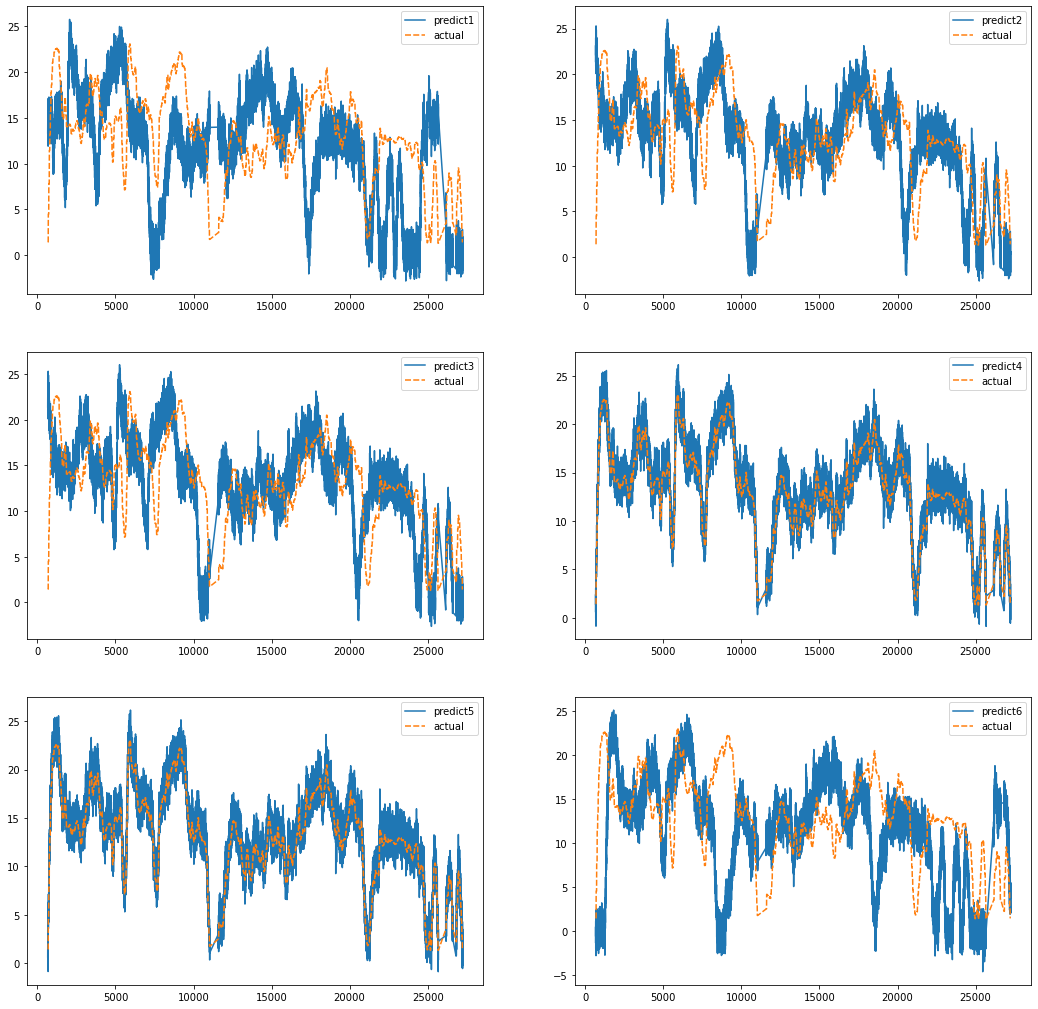

In [9]:
# R2 scores before synchronizing
score_before_sync = []

# Create a figure
plt.figure(figsize = (18, 18))

# Columns to iterate over
columns = signals_df.columns[1:7]
for i in range(len(columns)):
    plt.subplot(3, 2, i+1)
    sns.lineplot(data = signals_df[[columns[i], 'actual']])
    score_before_sync.append(r2_score(signals_df.actual, signals_df[columns[i]]))

In [10]:
score_before_sync

[-1.4994364845694363,
 -0.3716307510485297,
 -0.3716307510485297,
 0.9370035427991835,
 0.9370035427991835,
 -1.790784688568594]

### Synchronization Model

In [11]:
def synchronize(column1, column2):
#     Fill null values in columns with mean if applicable
    signals_df[column1] = signals_df[column1].fillna(signals_df[column1].mean())
    signals_df[column2] = signals_df[column2].fillna(signals_df[column2].mean())
    x = signals_df[column1]
    y = signals_df[column2]
    
    # using the dynamic time warping model:
    distance, path = fastdtw(x, y, dist = euclidean)
    result = []
    for i in range(0, len(path)):
        result.append([signals_df[column1].iloc[path[i][0]], signals_df[column2].iloc[path[i][1]]])
        
    data_sync = pd.DataFrame(data=result,columns=[column1, column2])
    return data_sync

### Apply scynchronization model and visualize resutls

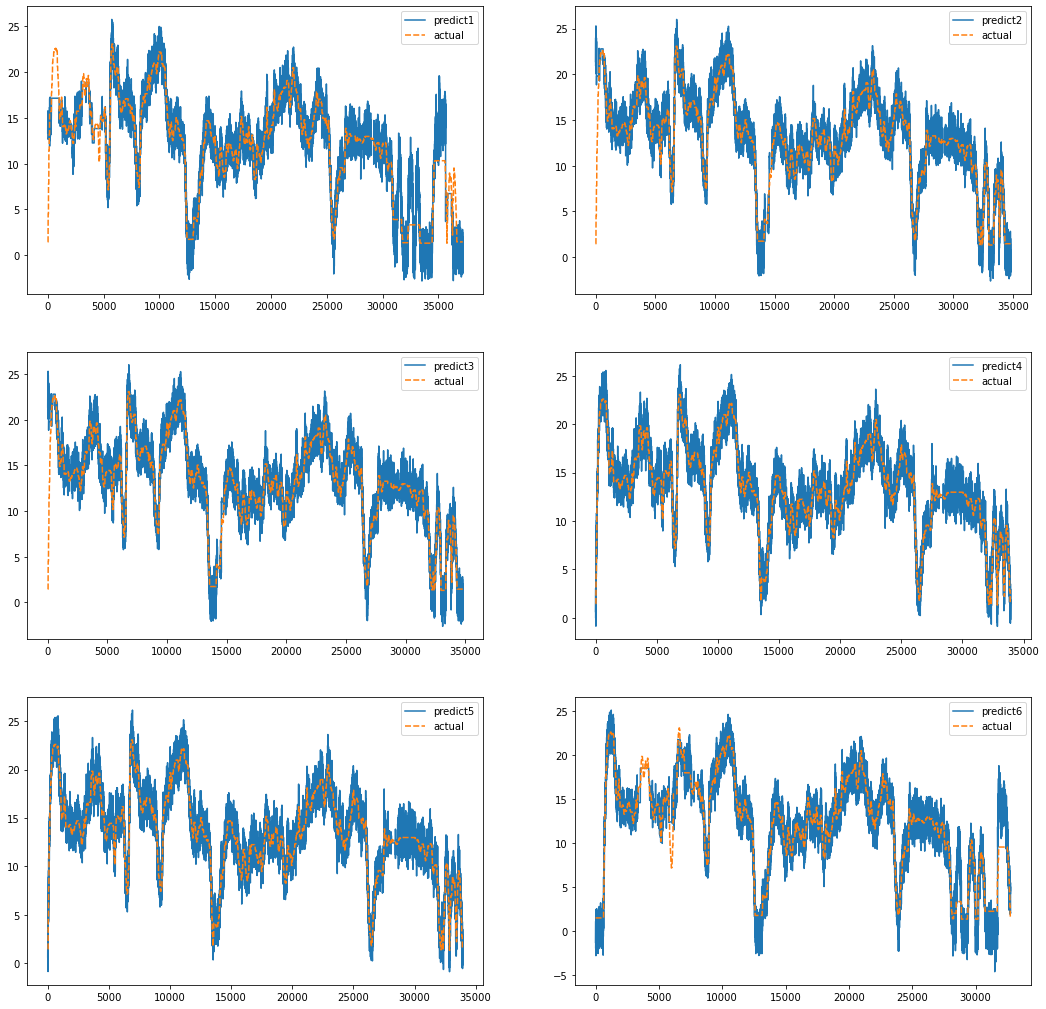

In [12]:
# Create a figure
plt.figure(figsize = (18, 18))

# Columns to synchronize
columns_to_sync = signals_df.columns[1:7]

# R2 Scores after synchronizing
score_after_sync = []

# Columns of new dataframe to store synced speed data
actual_p = ['actual_p1', 'actual_p2', 'actual_p3', 'actual_p4', 'actual_p5', 'actual_p6']

# Dataframe to store synced speed data
sync = pd.DataFrame(index = range(0, 38000))


for i in range(len(columns_to_sync)):
    
#     Apply synchronization model
    column_sync = synchronize('actual', columns_to_sync[i])
    
#     Add R2 Scores to list
    score_after_sync.append(r2_score(column_sync['actual'], column_sync[columns_to_sync[i]]))
    
#     Assign synced data to a column in new dataframe
    sync[columns_to_sync[i]] = column_sync[columns_to_sync[i]]
    sync[actual_p[i]] = column_sync.actual
    
#     Visualize synced speed data
    plt.subplot(3, 2, i+1)
    sns.lineplot(data = column_sync[[columns_to_sync[i], 'actual']])

In [13]:
# Synced speed data
sync

,predict1,actual_p1,predict2,actual_p2,predict3,actual_p3,predict4,actual_p4,predict5,actual_p5,predict6,actual_p6
0,13.367114,1.461281,21.399214,1.461281,21.399214,1.461281,0.642885,1.461281,0.642885,1.461281,-1.318396,1.461281
1,14.314806,1.461281,22.346906,1.461281,22.346906,1.461281,1.590577,1.461281,1.590577,1.461281,-0.370704,1.461281
2,13.739894,1.461281,21.771994,1.461281,21.771994,1.461281,1.015665,1.461281,1.015665,1.461281,-0.945616,1.461281
3,13.752769,1.461281,21.784869,1.461281,21.784869,1.461281,1.028540,1.461281,1.028540,1.461281,-0.932741,1.461281
4,13.422442,1.461281,21.454542,1.461281,21.454542,1.461281,0.698213,1.461281,0.698213,1.461281,-1.263068,1.461281
...,...,...,...,...,...,...,...,...,...,...,...,...
37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# R2 Scores after synchronization
score_after_sync

[0.8953872327584431,
 0.918982830178554,
 0.918982830178554,
 0.957858044801164,
 0.957858044801164,
 0.926750067903713]

In [19]:
scores = pd.DataFrame({'score_before_sync':score_before_sync, 'score_after_sync':score_after_sync})
scores

,score_before_sync,score_after_sync
0,-1.499436,0.895387
1,-0.371631,0.918983
2,-0.371631,0.918983
3,0.937004,0.957858
4,0.937004,0.957858
5,-1.790785,0.926750


### Saving as csv file

In [22]:
sync.to_csv('Synced Speed Data')